# Model Metrics on test set

- Plot Confusion Matrix
- Get test set accuracy score

In [25]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms as T
from sklearn.metrics import confusion_matrix, accuracy_score

from src.dataset import CarsDataset
from src.model import ClassifierModel
from src.config.load_config import read_yaml_file

In [26]:
# View test data
cfg = read_yaml_file()
test_df_path = "data/annotations/test_df.csv"
test_df = pd.read_csv(test_df_path)

test_df.shape

(8144, 8)

In [27]:
# mean and standard dev as per pre-trained imagenet dataset (https://pytorch.org/hub/pytorch_vision_resnet/)
mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]
transform = T.Compose([
                T.Resize([224,224]),
                T.ToTensor(),
                T.Normalize(mean=mean, std=std),
                ])

In [28]:
batch_size=2
num_class = test_df["class"].nunique()

In [29]:
# Create dataset for training run
path_to_data = os.path.join(os.getcwd(), "data/car_ims")
test_set = CarsDataset(csv_file=test_df_path, root_dir=path_to_data, transform=transform, custom_crop=False)

# Load the datasets into train and validation loaders respectively
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=4, shuffle=True)

In [30]:
# Load model and pth file
model_name = cfg["training"]["model_name"]
model_path = cfg["inference"]["model_path"]
model = ClassifierModel(num_class)
state_dict = torch.load(model_path, map_location='cpu')
model.load_state_dict(state_dict)
if torch.cuda.is_available():
    model.to("cuda")
model.eval()

print(f"model loaded is {model_name} at location {model_path}")

# run through test_df and append labels and targets
ls_ans, ls_labels = [], []
for i, (data, labels) in enumerate(tqdm(test_loader)):
    target = model(data)
    _, predicted = torch.max(target.detach(), 1)
    # print(predicted.detach().numpy().reshape(2,1))
    # print(labels.detach().numpy().reshape(2,1))
    ls_ans.append(predicted.detach().numpy().reshape(2,1))
    ls_labels.append(labels.detach().numpy().reshape(2,1))
    # if i ==100:
    #     break

100%|██████████| 4072/4072 [46:19<00:00,  1.46it/s]  


accuracy on test set is 95.26%


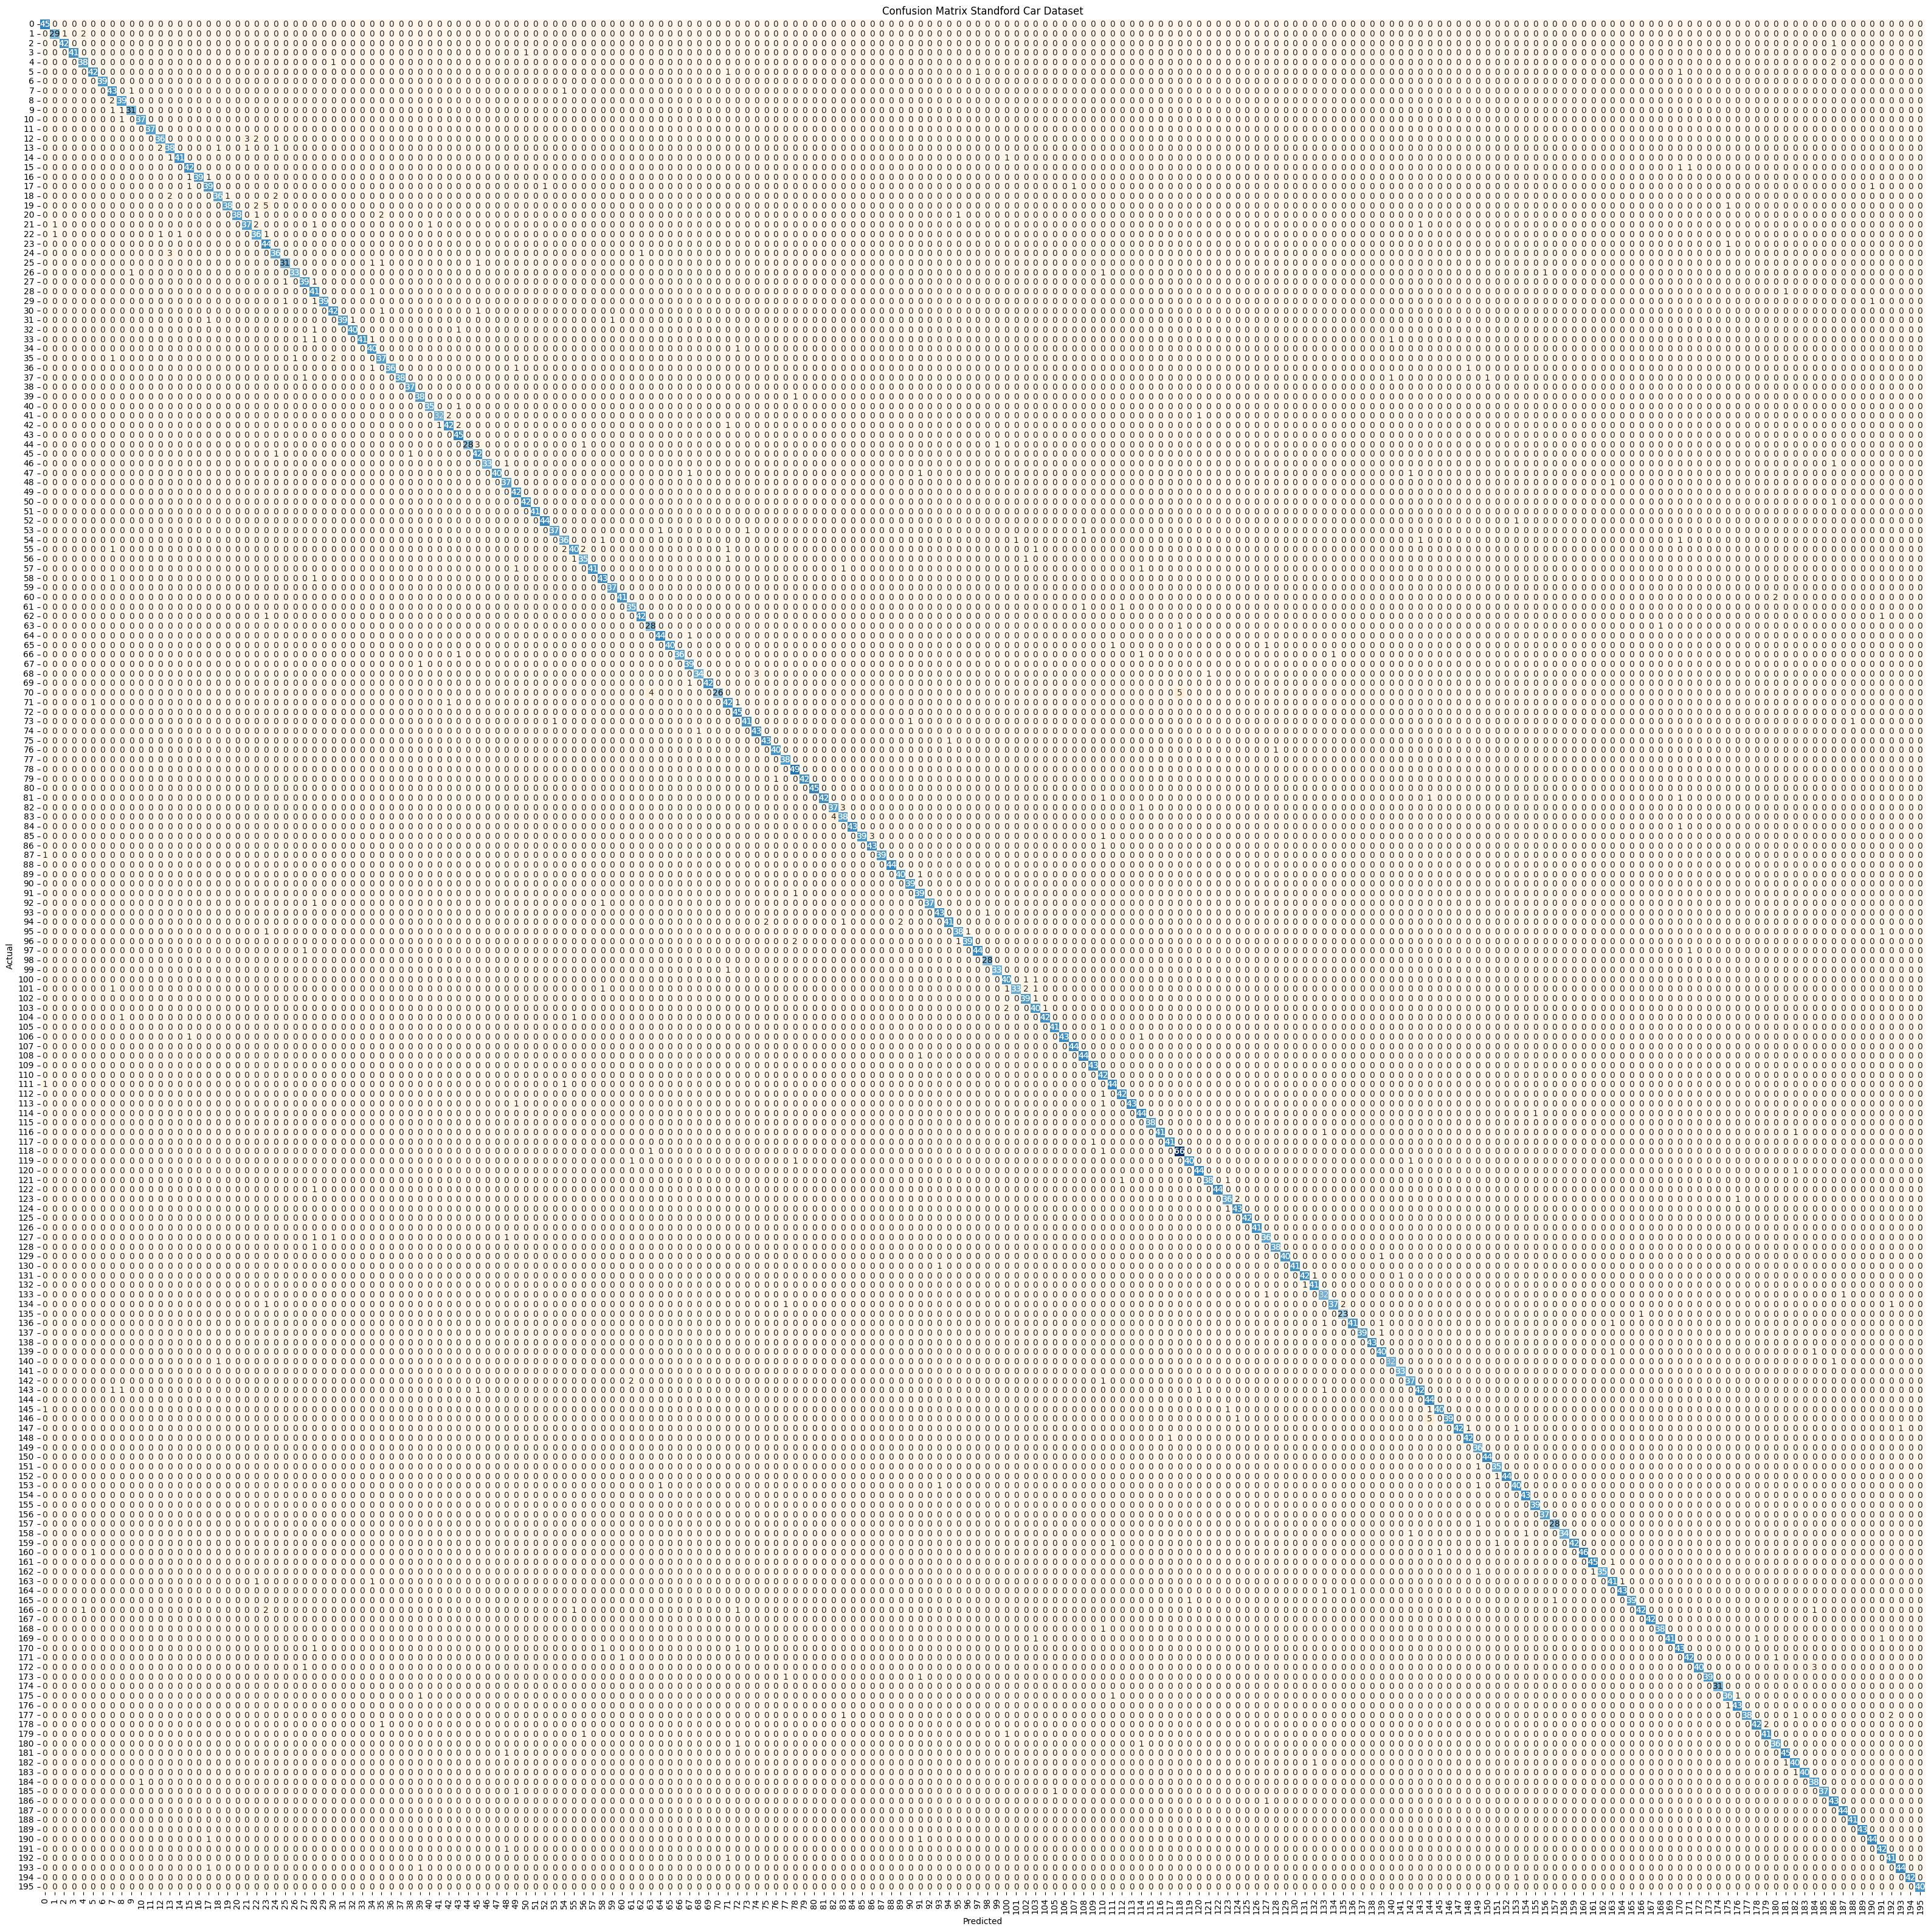

In [36]:

y_pred = np.vstack(ls_ans)
y_true = np.vstack(ls_labels)

cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
print(f"accuracy on test set is {acc*100:.2f}%")

def plot_confusion_matrix(cm, model_path):
    plt.figure(figsize=(40,40))
    vmin = np.min(cm)
    vmax = np.max(cm)    
    
    disp = sns.heatmap(cm, annot=True, cmap='OrRd', vmin=vmin, vmax=vmax, cbar=False)
    diag_nan = np.full_like(cm, np.nan, dtype=float)
    np.fill_diagonal(diag_nan, np.diag(cm))
    disp = sns.heatmap(diag_nan, annot=True, cmap='Blues', vmin=vmin, vmax=vmax, cbar_kws={'ticks':[]}, cbar=False)
    disp.set(title="Confusion Matrix Standford Car Dataset")
    disp.set(xlabel='Predicted', ylabel='Actual')
    fig = disp.get_figure()
    cm_name = str(os.path.splitext(model_path)[0]).split("/")[-1]
    fig.savefig(f"assets/{cm_name}_conf_mat.png") 

plot_confusion_matrix(cm, model_path)